In [1]:
import numpy as np
import os
import sys
import copy

import torch
from torch import nn
import scipy as sp

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy as sp
import scipy.interpolate as ip
import scipy.optimize as op
import scipy.signal as sg

np.random.seed(1)

In [10]:
data_pars = dict(
    # General parameters
    td=256,  # Number of points
    Fs=12800,  # Sampling frequency
    debug=False,  #  Print data generation details
    # Peak parameters
    pmin=1,  # Minimum number of Gaussians in a peak
    pmax=1,  # Maximum number of Gaussians in a peak
    ds=0.03,  # Spread of chemical shift values for each peak
    lw=[[5e1, 2e2], [1e2, 1e3]],  # Linewidth range for Gaussians
    iso_p=[0.8, 0.2],
    iso_p_peakwise=True,
    iso_int=[0.5, 1.0],  # Intensity
    phase=0.0,  # Spread of phase
    # Isotropic parameters
    nmin=1,  # Minimum number of peaks
    nmax=5,  # Maximum number of peaks
    shift_range=[2000.0, 10000.0],  # Chemical shift range
    positive=True,  # Force the spectrum to be positive
    # MAS-independent parameters
    # MAS-independent GLS broadening range
    mas0_lw_range=[0.0, 0.0],
    mas0_lw_p=[1.0],
    # MAS-independent GLS mixing paramter
    mas0_m_range=[[0.0, 0.1], [0.0, 1.0]],
    mas0_m_p=[0.8, 0.2],
    mas0_s_range=[0.0, 0.0],  # MAS-independent shift range
    mas0_s_p=[1.0],
    # MAS-dependent parameters
    # MAS-dependent GLS broadening range
    mas_lw_range=[[1e7, 1e8], [5e7, 2e8]],
    mas_lw_p=[0.8, 0.2],
    mas_m_range=[[1e4, 5e4]],  # MAS-dependent GLS mixing paramter
    mas_m_p=[1.0],
    mas_s_range=[-1.5e7, 1.5e7],  # MAS-dependent shift range
    mas_s_p=[1.0],
    # Second-order MAS-dependent parameters
    mas_w2=True,
    mas_w2_p=1.0,
    # Second-order MAS-dependent Gaussian broadening range
    mas2_lw_range=[[1e2, 1e4], [1e8, 1e9]],
    mas2_lw_p=[0.5, 0.5],
    # Second-order MAS-dependent Lorentzian broadening range
    mas2_m_range=[[0.0, 10], [1e4, 1e6]],
    mas2_m_p=[0.5, 0.5],
    # Second-order MAS-dependent shift range
    mas2_s_range=[[0.0, 0.0], [-2e11, 2e11]],
    mas2_s_p=[0.8, 0.2],
    # Other MAS-dependent mixing
    mas_other_mixing_p=0.5,
    mas_other_mixing_trends=["constant", "increase", "decrease"],
    mas_other_mixing_probs=[0.4, 0.3, 0.3],
    mas_other_mixing_range=[0.0, 1.0],
    # Add noise to linewidths
    mas_lw_noise=0.05,
    mas_s_noise=20.0,
    mas_phase=0.01,  # Random phase range for MAS spectra
    peakwise_phase=True,  # Whether the phase should be peak-wise or spectrum-wise
    encode_imag=False,  # Encode the imaginary part of the MAS spectra
    nw=8,  # Number of MAS rates
    mas_w_range=[30000, 100000],  # MAS rate range
    random_mas=True,
    encode_w=True,  # Encode the MAS rate of the spectra
    # Post-processing parameters
    noise=0.0,  # Noise level
    smooth_end_len=10,  # Smooth ends of spectra
    iso_norm=256.0,  #  Normalization factor for peaks
    brd_norm=64.0,  #  Normalization factor for MAS spectra
    offset=0.0,  # Baseline offset
    norm_wr=True,  # Normalize MAS rate values
    wr_inv=False,  # Encode inverse of MAS rate instead of MAS rate
)

loss_pars = dict(
    trg_fuzz=5.0,
    trg_fuzz_len=25,
    srp_w=1.0,
    srp_exp=2.0,
    srp_offset=1.0,
    srp_fac=100.,
    brd_w=1e-3,
    brd_sig=5.0,
    brd_len=25,
    brd_exp=2.0,
    brd_offset=1.0,
    brd_fac=0.,
    int_w=0.1,
    int_exp=2.0,
    int_edge=0,
    return_components=True,
)

train_pars = dict(
    batch_size=4,  # Dataset batch size
    num_workers=4,  # Number of parallel processes to generate data
    checkpoint=1000,  # Perform evaluation after that many batches
    n_eval=200,  # Number of batches in the evaluation
    max_checkpoints=200,  # Maximum number of checkpoints before finishing training
    out_dir="../data/sanity_check_2D/",  # Output directory
    change_loss={25: {"trg_fuzz": 3.0, "trg_fuzz_len": 15},
                   50: {"trg_fuzz": 0.0, "srp_fac": 0.0}},  # Checkpoints where loss parameter are updated
    avg_models=False,
    device="cuda" if torch.cuda.is_available() else "cpu",
    monitor_end="\n",
)

model_pars = dict(
    n_models=1,
    input_dim=2,
    hidden_dim=16,
    kernel_size=[5, 15],
    num_layers=2,
    final_kernel_size=5,
    batch_input=6,
    bias=True,
    final_bias=True,
    independent=True,
    return_all_layers=True,
    final_act="linear",
    noise=0.,
)

In [3]:
dataset = data.PIPDatasetGLS2D(data_pars, data_pars, rot_range=[-45.])

In [4]:
X, Y, XY, x, y, xy = dataset.__getitem__(0)

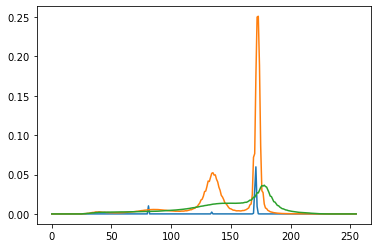

In [5]:
plt.plot(xy[0, 50])
plt.plot(XY[-1, 0, 50])
plt.plot(XY[0, 0, 50])
#plt.xlim(8000, 10000)
plt.show()
plt.close()

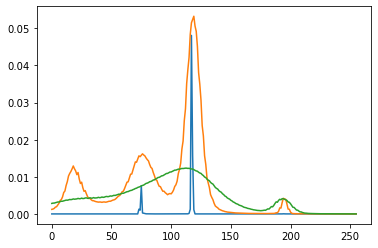

In [6]:
plt.plot(xy[0, :, 103])
plt.plot(XY[-1, 0, :, 103])
plt.plot(XY[0, 0, :, 103])
#plt.xlim(8000, 10000)
plt.show()
plt.close()

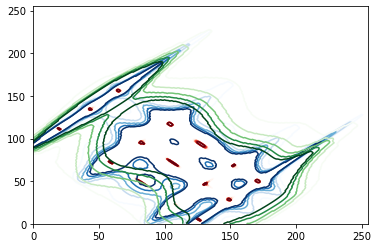

In [7]:
plt.contour(xy[0], levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Reds")
plt.contour(XY[-1, 0], levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Blues")
plt.contour(XY[0, 0], levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Greens")

In [11]:
net = model.ConvLSTMEnsemble(**model_pars)

opt = torch.optim.Adam(
    net.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)

loss = model.CustomLoss(**loss_pars, device=train_pars["device"])

sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)

In [12]:
for XYi in XY:
    l, comps = loss(XYi[0].unsqueeze(0).repeat(1, 1, 3, 1, 1), xy.repeat(1, 1, 3, 1, 1))
    print(l.item())
    print(comps)

l, comps = loss(torch.zeros_like(XYi[0].unsqueeze(0)).repeat(1, 1, 3, 1, 1), xy.repeat(1, 1, 3, 1, 1))
print(l.item())
print(comps)

0.0057530184276402
[0.005343277473002672, 0.00040915870340541005, 5.820618298457703e-07]
0.005156999919563532
[0.004803990479558706, 0.0003524481726344675, 5.609344384538417e-07]
0.004308310803025961
[0.00401734746992588, 0.00029040861409157515, 5.545461476685887e-07]
0.004546906799077988
[0.004242785274982452, 0.00030355993658304214, 5.614180622615095e-07]
0.004382238257676363
[0.004087064880877733, 0.0002946212771348655, 5.522330752683047e-07]
0.004289694130420685
[0.004000576213002205, 0.0002885640424210578, 5.537560241464234e-07]
0.004437140189111233
[0.004138680640608072, 0.0002979058481287211, 5.536253979698813e-07]
0.0040249391458928585
[0.003757002530619502, 0.0002673903072718531, 5.463752472678607e-07]
0.007095360197126865
[0.006470186170190573, 0.0006221532821655273, 3.0205360417312477e-06]


In [10]:
for i in range(1000):
    
    print(i)
    
    net.zero_grad()
    
    y_preds, y_errs, ys = net(XY.unsqueeze(0))
    
    l, components = loss(ys, xy.repeat(1, 1, 3, 1, 1))
    
    print(l.item())
    print(components)
    
    l.backward()
    opt.step()

0
0.00537203811109066
[0.005025195423513651, 0.00018076378910336643, 0.00016607913130428642]
1
0.01000884734094143
[0.009756256826221943, 0.00014017635839991271, 0.00011241397442063317]
2
0.00559312105178833
[0.005547391250729561, 3.4366406907793134e-05, 1.136348600994097e-05]
3
0.005205899011343718
[0.004900507163256407, 0.00016036228043958545, 0.00014502971316687763]
4
0.006367713678628206
[0.005770094692707062, 0.00030392518965527415, 0.0002936941455118358]
5
0.0063152192160487175
[0.0057250200770795345, 0.0003002310113515705, 0.0002899683022405952]
6
0.005591012071818113
[0.0051657091826200485, 0.00021914434910286218, 0.0002061584236798808]
7
0.005042506847530603
[0.004783760290592909, 0.00013745279284194112, 0.00012129381502745673]
8
0.004897297825664282
[0.004750161897391081, 8.294338476844132e-05, 6.419212877517566e-05]
9
0.0050227707251906395
[0.004934045020490885, 5.4616615670965984e-05, 3.410942372283898e-05]
10
0.005209673196077347
[0.005145590286701918, 4.278885535313748e-0

KeyboardInterrupt: 

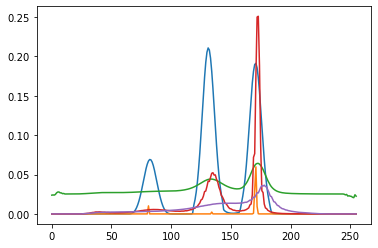

In [11]:
plt.plot(loss.trg_filt(xy)[0, 50])
plt.plot(xy[0, 50])
plt.plot(ys[0, 0, 0, 50].detach())
plt.plot(XY[-1, 0, 50])
plt.plot(XY[0, 0, 50])
#plt.xlim(8000, 10000)
plt.show()
plt.close()

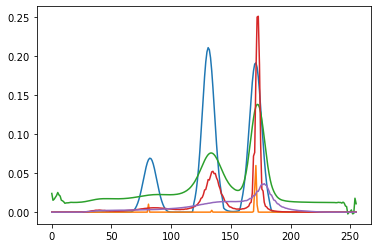

In [15]:
plt.plot(loss.trg_filt(xy)[0, 50])
plt.plot(xy[0, 50])
plt.plot(ys[0, 0, -1, 50].detach())
plt.plot(XY[-1, 0, 50])
plt.plot(XY[0, 0, 50])
#plt.xlim(8000, 10000)
plt.show()
plt.close()

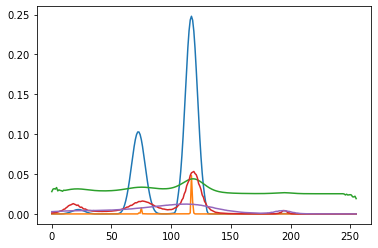

In [18]:
plt.plot(loss.trg_filt(xy)[0, :, 103])
plt.plot(xy[0, :, 103])
plt.plot(ys[0, 0, 0, :, 103].detach())
plt.plot(XY[-1, 0, :, 103])
plt.plot(XY[0, 0, :, 103])
#plt.xlim(8000, 10000)
plt.show()
plt.close()

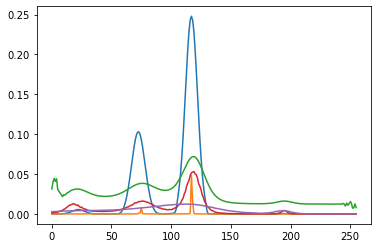

In [19]:
plt.plot(loss.trg_filt(xy)[0, :, 103])
plt.plot(xy[0, :, 103])
plt.plot(ys[0, 0, -1, :, 103].detach())
plt.plot(XY[-1, 0, :, 103])
plt.plot(XY[0, 0, :, 103])
#plt.xlim(8000, 10000)
plt.show()
plt.close()

In [ ]:
plt.contour(xy[0], levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Greys")
plt.contour(ys[0, 0, -1].detach(), levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Reds")
plt.contour(XY[-1, 0], levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Blues")
plt.contour(XY[0, 0], levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Greens")